In [1]:
#pip install -U nltk

In [2]:
import numpy as np
import pandas as pd
from gensim.models.word2vec import Word2Vec
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Conv1D, MaxPool1D, GlobalMaxPool1D, Embedding, Activation
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem.snowball import PorterStemmer
from sklearn import preprocessing

from gensim.parsing.preprocessing import remove_stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix



Using TensorFlow backend.


In [3]:
df = pd.read_csv("3000tweet/3000tweet.csv", sep=';',encoding="utf8")

In [4]:
df.head()

,tweet,durum
0,dun Turkcelle tepkilerimizden sonra bugün Turk...,1
1,girmezmiyim.. Turkcell kartim bile var.. Yarin...,1
2,tam tünelden gecerken 3g cekiyordu :D türkcell...,1
3,turkcell superonline fiber internet veya ADSL ...,1
4,bence Gnçtrkcll Ark Winterfest 2012'de 1.olur ...,1


In [5]:
df.isna().sum()

tweet    1
durum    0
dtype: int64

In [6]:
df.dropna(inplace=True)

In [7]:
df.isna().sum()

tweet    0
durum    0
dtype: int64

In [8]:
def preprocess_text(sen):
    
    #Remove numeric
    #sentence = re.sub('[\d\s]', ' ', str(sen))

    # Remove punctuations and numbers
    sentence = re.sub('[^\w\s]', ' ', str(sen))
    
    #Single character removal
    sentence = re.sub(r"\b[\w\s]\b", ' ',str(sentence))
    
    #Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    stop_word_list = stopwords.words('turkish')
    
    tokens = WPT.tokenize(sentence)
    filtered_tokens = [token for token in tokens if token not in stop_word_list]
    single_doc = ' '.join(filtered_tokens)

    return single_doc.lower()


In [9]:
WPT = nltk.WordPunctTokenizer()
df['tweet'] = df['tweet'].apply(preprocess_text)

In [10]:
df[:10]

,tweet,durum
0,dun turkcelle tepkilerimizden sonra bugün turk...,1
1,girmezmiyim turkcell kartim bile var yarindan ...,1
2,tam tünelden gecerken 3g cekiyordu türkcell in...,1
3,turkcell superonline fiber internet adsl sabit...,1
4,bence gnçtrkcll ark winterfest 2012 olur gelir,1
5,turkcell sana kıyak geçiyor,1
6,turkcelle bağlan hayata diyorum,1
7,kimse takmıyo beni yaaaaa turkcell bana mesaj ...,1
8,bu turkcell pusula uygulaması iphone kullanıcı...,1
9,zaman sorun yok bende turkcell iyi bir tarife ...,1


In [11]:
mes = []
for i in df['tweet']:
    mes.append(i.split())
print(mes[:2])

[['dun', 'turkcelle', 'tepkilerimizden', 'sonra', 'bugün', 'turkcell', 'twittera', 'sponsor', 'olmuş', 'ne', 'tesadüf', 'değil'], ['girmezmiyim', 'turkcell', 'kartim', 'bile', 'var', 'yarindan', 'itibaren', 'onu', 'takicam', 'twittersiz', 'denedim', 'sadece', 'gun', 'yapabildim']]


In [12]:
word2vec_model = Word2Vec(mes, size=500, window=3, min_count=1, workers=16)
print(word2vec_model)

Word2Vec(vocab=12037, size=500, alpha=0.025)


In [13]:
token = Tokenizer(11748)
token.fit_on_texts(df['tweet'])
text = token.texts_to_sequences(df['tweet'])
text = pad_sequences(text, 25)
print(text[:2])

[[   0    0    0    0    0    0    0    0    0    0    0    0    0  637
   402 3241   29   34    1 3242  954  161   64 1827   37]
 [   0    0    0    0    0    0    0    0    0    0    0 3243    1 3244
    33    9 3245 1828  204 3246 3247  775   45  174 3248]]


In [14]:
le = preprocessing.LabelEncoder()
y = le.fit_transform(df['durum'])
y = to_categorical(y)

In [15]:
x_train, x_test, y_train, y_test = train_test_split(np.array(text), y, test_size=0.2, stratify=y)

In [16]:
keras_model = Sequential()
keras_model.add(word2vec_model.wv.get_keras_embedding(True))
keras_model.add(Dropout(0.2))
keras_model.add(Conv1D(50, 3, activation='relu', padding='same', strides=1))
keras_model.add(Conv1D(50, 3, activation='relu', padding='same', strides=1))
keras_model.add(MaxPool1D())
keras_model.add(Dropout(0.2))
keras_model.add(Conv1D(100, 3, activation='relu', padding='same', strides=1))
keras_model.add(Conv1D(100, 3, activation='relu', padding='same', strides=1))
keras_model.add(MaxPool1D())
keras_model.add(Dropout(0.2))
keras_model.add(Conv1D(200, 3, activation='relu', padding='same', strides=1))
keras_model.add(Conv1D(200, 3, activation='relu', padding='same', strides=1))
keras_model.add(GlobalMaxPool1D())
keras_model.add(Dropout(0.2))
keras_model.add(Dense(200))
keras_model.add(Activation('relu'))
keras_model.add(Dropout(0.2))
keras_model.add(Dense(3))
keras_model.add(Activation('softmax'))
keras_model.compile(loss='binary_crossentropy', metrics=['acc'], optimizer='adam')
history=keras_model.fit(x_train, y_train, batch_size=16, epochs=3, validation_data=(x_test, y_test))

D:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2399 samples, validate on 600 samples
Epoch 1/3
2399/2399 [==============================] - 13s 6ms/step - loss: 0.6202 - acc: 0.6742 - val_loss: 0.5939 - val_acc: 0.6933
Epoch 2/3
2399/2399 [==============================] - 13s 5ms/step - loss: 0.5023 - acc: 0.7452 - val_loss: 0.5618 - val_acc: 0.7133
Epoch 3/3
2399/2399 [==============================] - 13s 5ms/step - loss: 0.3431 - acc: 0.7996 - val_loss: 0.6589 - val_acc: 0.6983


In [17]:
keras_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 500)         6018500   
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 500)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 50)          75050     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 50)          7550      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 50)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 100)        

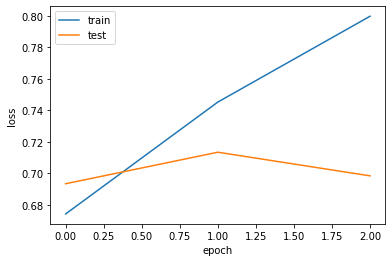

In [18]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
#pred = keras_model.predict_classes(x_test)

In [20]:
#accuracy = word2vec_model.accuracy(pred)


In [21]:
#rounded_labels=np.argmax(y_test, axis=1)

In [22]:
#cm = confusion_matrix(rounded_labels,pred)

In [23]:
#class_names = ['Olumlu','Olumsuz','Nötr']
#cm = pd.DataFrame(cm , index = class_names , columns = class_names)
#plt.figure(figsize = (5,5))
#sns.heatmap(cm,cmap= "Blues", linecolor = 'black' ,cbar=False, linewidth = 1 , annot = True, fmt='' , xticklabels = class_names , yticklabels = class_names)